In [ ]:
import networkx as nx
import json
import numpy as np
import matplotlib.pyplot as plt

# --- Load POS tags with attributes ---
with open("pos_tags.json", "r", encoding="utf-8") as f:
    pos_tags = json.load(f)

# --- Create graph ---
G = nx.Graph()

# --- Load edge list ---
file = open("cooccurrence_pairs_window2.txt", "rb")
G = nx.read_edgelist(file, delimiter="\t")

# --- Add node attributes from pos_tags ---
for node in G.nodes():
    if node.lower() in pos_tags:
        G.nodes[node]["pos"] = pos_tags[node.lower()].get("pos")
        G.nodes[node]["gender"] = pos_tags[node.lower()].get("gender")
    else:
        G.nodes[node]["pos"] = None
        G.nodes[node]["gender"] = None



In [37]:
print(G.number_of_edges()), print(G.number_of_nodes())

27887
25243


(None, None)

In [38]:
degree_centrality = nx.degree_centrality(G)

# Get node with maximum centrality
max_degree_node = max(degree_centrality, key=degree_centrality.get)

node_name = max_degree_node  
node_attrs = G.nodes[max_degree_node]

print(f"Node with highest degree centrality: {node_name}")
print(f"Centrality: {degree_centrality[max_degree_node]}")
print(f"Attributes: {node_attrs}")


Node with highest degree centrality: Jack
Centrality: 0.005585928214879962
Attributes: {'pos': 'PERSON', 'gender': 'male'}


Text(0, 0.5, 'Frequency')

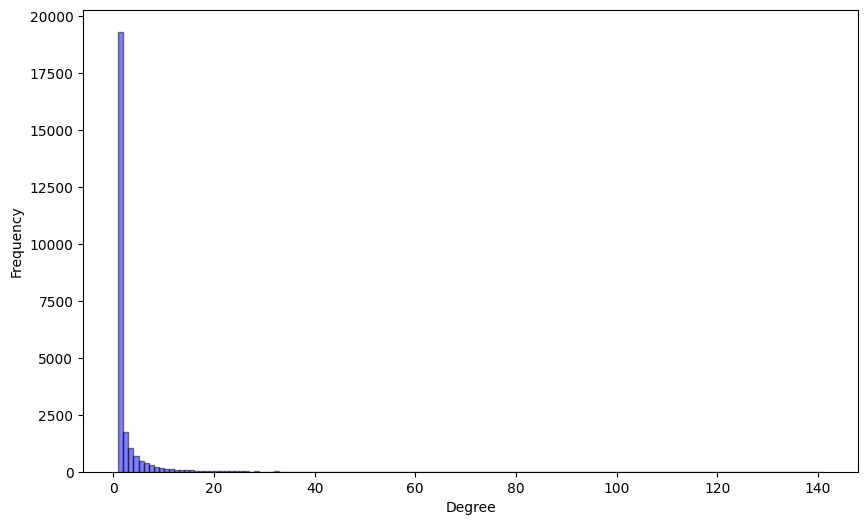

In [39]:
degree = dict(G.degree())
min_degree, max_degree = min(degree.values()), max(degree.values())
degree_vector = np.arange(min_degree, max_degree + 1)
degree_hist = np.histogram(list(degree.values()), bins=degree_vector)

plt.figure(figsize=(10, 6))
plt.hist(degree.values(), bins=degree_hist[1], color='blue', alpha=0.5, edgecolor='black')
# plt.title('Degree Distribution', size=40)
plt.xlabel('Degree')
plt.ylabel('Frequency')

In [40]:
sorted(G.degree(), key=lambda x: x[1], reverse=True)[:10]

[('Jack', 141),
 ('Jack\r', 131),
 ('Jim', 113),
 ('Mr\r', 102),
 ('Jim\r', 100),
 ('John', 86),
 ('King\r', 82),
 ('John\r', 79),
 ('Christmas\r', 75),
 ('Queen', 75)]

<BarContainer object of 3 artists>

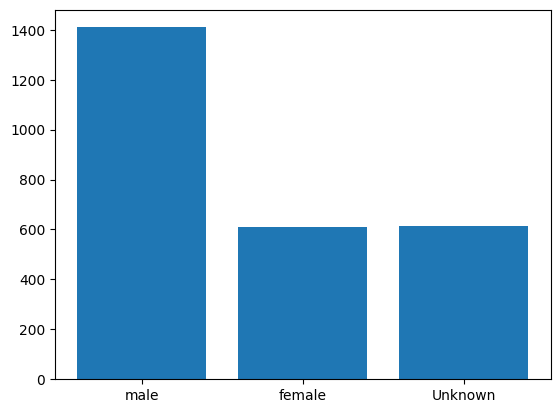

In [30]:
# Get gender of nodes
genders_in_graph = [G.nodes[node]["gender"] for node in G.nodes() if G.nodes[node]["gender"] is not None]
dict_ = {}
for gender in genders_in_graph:
    if gender not in dict_:
        dict_[gender] = 1
    else:
        dict_[gender] += 1

# Plot gender distribution
plt.bar(dict_.keys(), dict_.values())

In [32]:
dict_

{'male': 1410, 'female': 609, 'Unknown': 612}

In [31]:
for node in G.nodes:
    if G.nodes[node]['gender'] == 'A':
        print(node)